# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import roc_curve
from scipy.stats import ks_2samp

In [39]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [41]:
def bivariada_qualitativa(dataframe:pd.DataFrame, x:str, y:str) -> pd.DataFrame:
    
    tabela_cruzada = pd.crosstab(index=dataframe[x], 
                                 columns=dataframe[y], 
                                 margins=True, 
                                 margins_name='total')
    
    tabela_cruzada['prob'] = tabela_cruzada[1] / tabela_cruzada['total']
    
    tabela_cruzada['odds'] = tabela_cruzada[1] / tabela_cruzada[0]
    tabela_cruzada['odds_ratio'] = tabela_cruzada['odds'] / tabela_cruzada.loc['total', 'odds']

    tabela_cruzada['logito'] = np.log(tabela_cruzada['odds'])
    tabela_cruzada['WOE'] = np.log(tabela_cruzada['odds'] / tabela_cruzada.loc['total', 'odds'])
    
    return tabela_cruzada

In [42]:
bivariada_qualitativa(dataframe=df, x='sex', y='flag_doente')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [43]:
bivariada_qualitativa(dataframe=df, x='cp', y='flag_doente')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [44]:
bivariada_qualitativa(dataframe=df, x='exang', y='flag_doente')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
exang,,,,,,,,
0.0,141,63,204,0.308824,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,0.767677,3.304348,3.898655,1.195239,1.360632
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


Qual delas parece discriminar mais o risco?

Entre as três variáveis, a exang (dor no peito causada por exercício) parece ser a melhor para discriminar o risco.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [45]:
def tab_func_2(df, resposta, explicativa, num_categorias=5):
    df['grupo'] = pd.qcut(df[explicativa], num_categorias, duplicates='drop')
    tab = pd.crosstab(df['grupo'], df[resposta], margins=True)
    tab['media'] = tab[1] / tab['All']
    tab['odds'] = tab['media'] / (1 - tab['media'])
    tab['odds_ratio'] = tab['odds'] / tab.loc['All', 'odds']
    tab['logito'] = np.log(tab['odds'])
    tab['woe'] = np.log(tab['odds_ratio'])
    return tab



In [46]:
tab_age = tab_func_2(df=df, resposta='flag_doente', explicativa='age')
tab_age

flag_doente,0,1,All,media,odds,odds_ratio,logito,woe
grupo,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [47]:
tab_trestbps = tab_func_2(df=df, resposta='flag_doente', explicativa='trestbps')
tab_trestbps

flag_doente,0,1,All,media,odds,odds_ratio,logito,woe
grupo,,,,,,,,
"(93.999, 120.0]",60,37,97,0.381443,0.616667,0.727578,-0.483427,-0.318034
"(120.0, 126.0]",10,15,25,0.600000,1.500000,1.769784,0.405465,0.570858
"(126.0, 134.0]",35,27,62,0.435484,0.771429,0.910175,-0.259511,-0.094119
"(134.0, 144.6]",34,24,58,0.413793,0.705882,0.832840,-0.348307,-0.182914
"(144.6, 200.0]",25,36,61,0.590164,1.440000,1.698993,0.364643,0.530036
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [48]:
reglog = smf.logit('flag_doente ~ C(sex) + C(cp, Treatment(4)) + trestbps + age', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Sun, 07 Jan 2024   Pseudo R-squ.:                  0.3097
Time:                        17:05:27   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -5.8619      1.413     -4.147      0.000      -8.632      -3.092
C(sex)[T.1.0]                  1.8094      0.353      5.130      0.000       1.118       2.501
C(cp, Treatment(4))[T.1.0]    -2.4789      0.553     -4.485      0.000      -3.562      -1.396
C(cp, Treatment(4))[T.2.0]    -2.5406      0.452     -5.622      0.000      -3.426      -1.655
C(cp, Treatment(4))[T.3.0]    -2.4074      0.360     -6.690      0.000      -3.113      -1.702
trestbps                       0.0193      0.009      2.261      0.024       0.003       0.036
age                            0.0567      0.018      3.120      0.002       0.021       0.092
==============================================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [49]:
df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,grupo,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(144.6, 200.0]",0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(144.6, 200.0]",0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(93.999, 120.0]",0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(126.0, 134.0]",0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(126.0, 134.0]",0.027278


In [50]:
cat_pred = pd.qcut(df['predito'], 5, duplicates='drop')
cat_pred.value_counts().sort_index()

predito
(0.0131, 0.143]    62
(0.143, 0.287]     59
(0.287, 0.586]     62
(0.586, 0.822]     59
(0.822, 0.944]     61
Name: count, dtype: int64

In [51]:
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count().rename(columns={'flag_doente': 'contagem'})
qualid['predito'] = group_reg['predito'].mean()
qualid

,contagem,predito
predito,,
"(0.0131, 0.143]",62,0.072008
"(0.143, 0.287]",59,0.209626
"(0.287, 0.586]",62,0.435175
"(0.586, 0.822]",59,0.708861
"(0.822, 0.944]",61,0.874819


In [52]:
qualid['pct_doente'] = group_reg['flag_doente'].mean()
qualid

,contagem,predito,pct_doente
predito,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


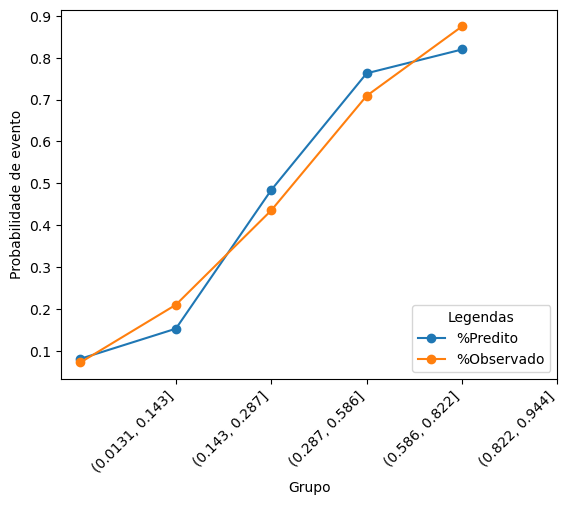

In [56]:
fig, ax = plt.subplots()

# Plotar as linhas
qualid['pct_doente'].plot(label='%Predito', marker='o', ax=ax)
qualid['predito'].plot(label='%Observado', marker='o', ax=ax)

# Ajustar rótulos e legendas
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')
ax.set_xticks(range(1, len(qualid) + 1))
ax.legend(loc="lower right", title='Legendas')

# Rotacionar rótulos do eixo x em 45 graus
ax.set_xticklabels(qualid.index, rotation=45, ha='right')

plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

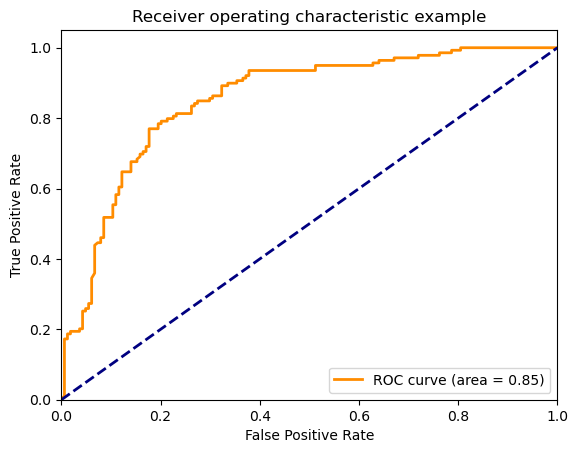

In [59]:
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

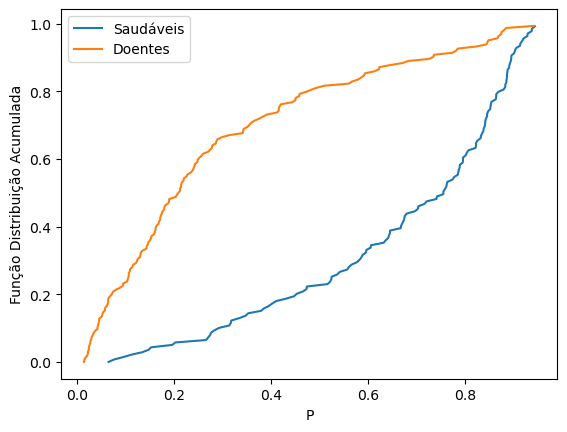

In [60]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente'] == 1, 'predito']
ax.plot(np.sort(score_pop1), np.linspace(
    0, 1, len(score_pop1), endpoint=False), label='Saudáveis')

score_pop2 = df.loc[df['flag_doente'] != 1, 'predito']
ax.plot(np.sort(score_pop2), np.linspace(
    0, 1, len(score_pop2), endpoint=False), label='Doentes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

In [62]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito'] > .5)
print('Acurácia: {0:.2f}%'.format(acc*100))

# AUC
fpr, tpr, thresholds = metrics.roc_curve(
    df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
# Gini
gini = 2*auc_ - 1
# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'],
              df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.54%
KS: 59.30% 
AUC: 85.19% 
GINI: 70.39%


6. Tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [64]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,grupo,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(144.6, 200.0]",0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(144.6, 200.0]",0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(93.999, 120.0]",0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(126.0, 134.0]",0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(126.0, 134.0]",0.027278
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0,0,"(93.999, 120.0]",0.248317
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3,1,"(134.0, 144.6]",0.586371
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0,0,"(93.999, 120.0]",0.420733
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2,1,"(126.0, 134.0]",0.883115
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1,1,"(134.0, 144.6]",0.838687


In [65]:
reglog_2 = smf.logit('flag_doente ~ C(sex) + C(cp, Treatment(4)) + trestbps + C(exang) + age + oldpeak + slope', data=df).fit()
reglog_2.summary()

Optimization terminated successfully.
         Current function value: 0.414322
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Sun, 07 Jan 2024   Pseudo R-squ.:                  0.3993
Time:                        17:11:01   Log-Likelihood:                -125.54
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.724e-31
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -6.6457      1.613     -4.121      0.000      -9.806      -3.485
C(sex)[T.1.0]                  1.7680      0.389      4.548      0.000       1.006       2.530
C(cp, Treatment(4))[T.1.0]    -2.4940      0.604     -4.128      0.000      -3.678      -1.310
C(cp, Treatment(4))[T.2.0]    -1.6177      0.484     -3.343      0.001      -2.566      -0.669
C(cp, Treatment(4))[T.3.0]    -2.1136      0.411     -5.138      0.000      -2.920      -1.307
C(exang)[T.1.0]                0.9253      0.364      2.541      0.011       0.211       1.639
trestbps                       0.0154      0.010      1.620      0.105      -0.003       0.034
age                            0.0463      0.019      2.426      0.015       0.009       0.084
oldpeak                        0.6039      0.192      3.145      0.002       0.228       0.980
slope                          0.4873      0.310      1.574      0.115      -0.119       1.094
==============================================================================================
"""

In [66]:
df['predito'] = reglog_2.predict(df)

acc = metrics.accuracy_score(df['flag_doente'], df['predito'] > .5)
print('Acurácia: {0:.2f}%'.format(acc*100))

# AUC
fpr, tpr, thresholds = metrics.roc_curve(
    df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
# Gini
gini = 2*auc_ - 1
# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'],
              df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 82.18%
KS: 67.60% 
AUC: 88.94% 
GINI: 77.88%
